# Liberias 

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [ ]:
#ruta para los csv en data/processed
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Subir un nivel
DATA_DIR = os.path.join(BASE_DIR, "data", "processed") 

# Rand-Forest

## Feaure Importance
Medimos la importancia de cada variable para ver las que vamosa considerar en nuestro modelo



🔍 Evaluando importancia de variables en: v1


,Variable,Importancia
21,Tiempo,0.793701
13,Zona_Renta,0.092084
17,COSTE_VENTA,0.032018
18,km_anno,0.019135
0,PRODUCTO,0.012393
1,TIPO_CARROCERIA,0.007483
9,PROVINCIA,0.006006
10,Campanna1,0.005547
15,Averia_grave,0.005018
5,FORMA_PAGO,0.004881


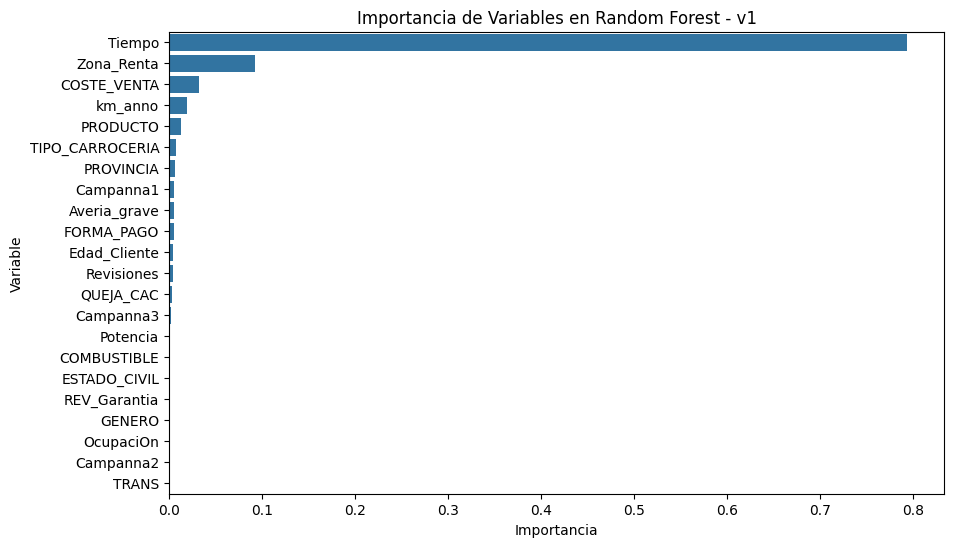


🔍 Evaluando importancia de variables en: v2


,Variable,Importancia
21,Tiempo,0.806694
13,Zona_Renta,0.082641
17,COSTE_VENTA,0.033894
18,km_anno,0.023683
0,PRODUCTO,0.010270
1,TIPO_CARROCERIA,0.005610
10,Campanna1,0.005535
9,PROVINCIA,0.004976
5,FORMA_PAGO,0.004794
19,Revisiones,0.004143


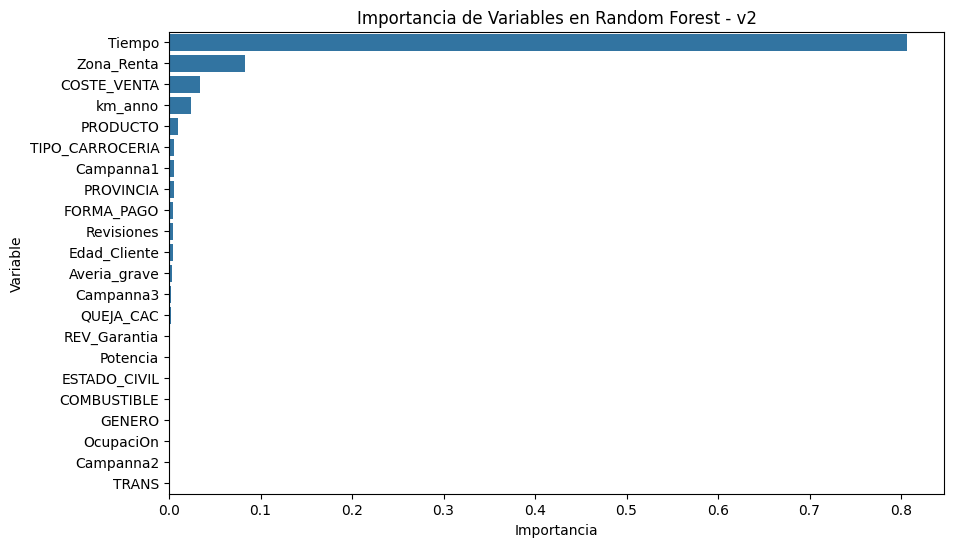


🔍 Evaluando importancia de variables en: v3


,Variable,Importancia
21,Tiempo,0.846439
17,COSTE_VENTA,0.038409
13,Zona_Renta,0.036537
18,km_anno,0.025661
0,PRODUCTO,0.009885
5,FORMA_PAGO,0.005931
10,Campanna1,0.005545
19,Revisiones,0.005255
9,PROVINCIA,0.004784
1,TIPO_CARROCERIA,0.004194


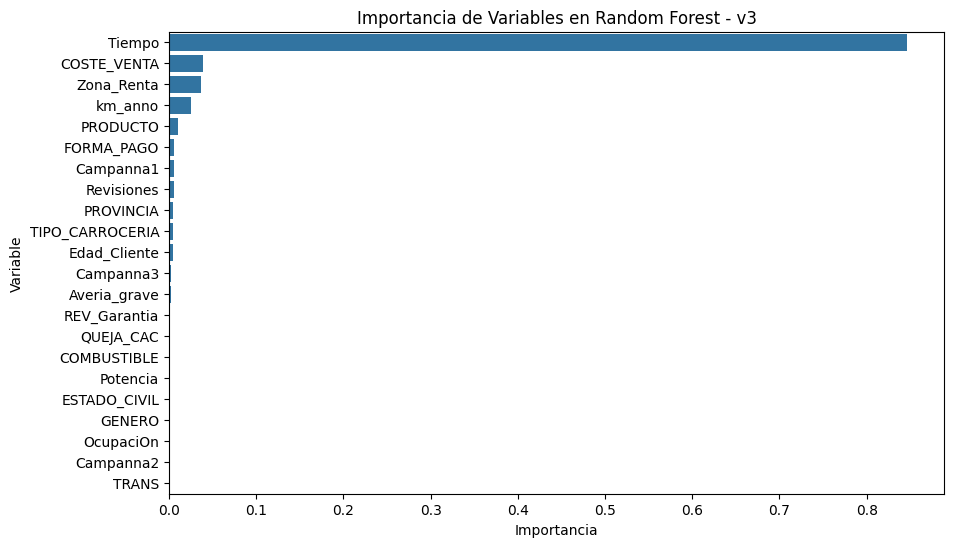


🔍 Evaluando importancia de variables en: v4


,Variable,Importancia
21,Tiempo,0.838849
13,Zona_Renta,0.040258
17,COSTE_VENTA,0.037599
18,km_anno,0.025243
0,PRODUCTO,0.010297
5,FORMA_PAGO,0.006506
19,Revisiones,0.005976
10,Campanna1,0.005543
9,PROVINCIA,0.005488
20,Edad_Cliente,0.004595


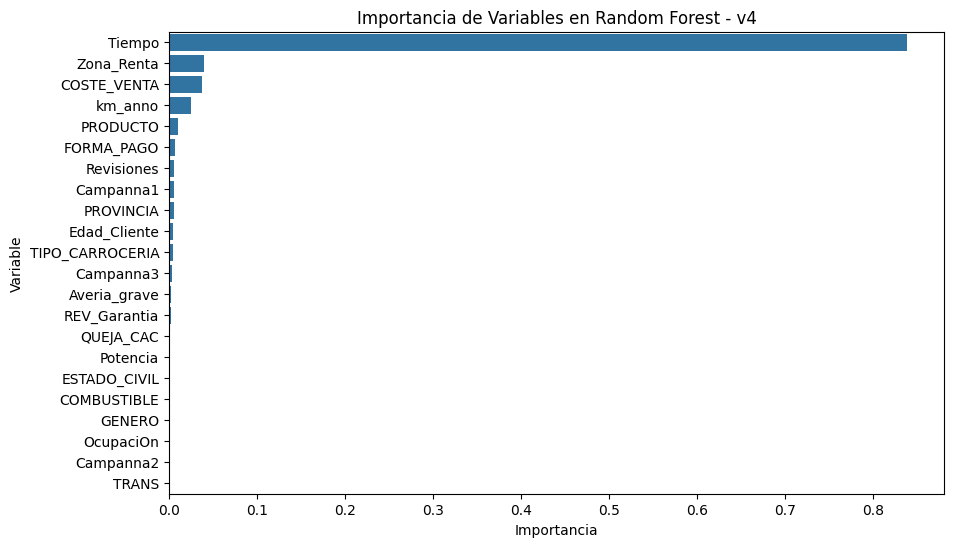

In [11]:
def evaluar_importancia_variables(data_dir):
    resultados = {}

    # Lista de archivos esperados
    file_paths = {
        "v1": os.path.join(data_dir, "Propensity_clean_v1.csv"),
        "v2": os.path.join(data_dir, "Propensity_clean_v2.csv"),
        "v3": os.path.join(data_dir, "Propensity_clean_v3.csv"),
        "v4": os.path.join(data_dir, "Propensity_clean_v4.csv"),
    }

    for version, path in file_paths.items():
        print(f"\n🔍 Evaluando importancia de variables en: {version}")

        # Cargar los datos
        df = pd.read_csv(path)

        # Verificar si la columna "Mas_1_coche" está presente y eliminar columnas problemáticas
        if "Mas_1_coche" in df.columns:
            y = df["Mas_1_coche"]
            X = df.drop(columns=["Mas_1_coche"], errors="ignore")
        # Eliminar columnas no numéricas si existen
        X = X.select_dtypes(include=['number'])

        # Dividir en entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Entrenar un Random Forest básico
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)

        # Obtener importancia de variables
        importances = rf.feature_importances_
        feature_importance_df = pd.DataFrame({"Variable": X.columns, "Importancia": importances})
        feature_importance_df = feature_importance_df.sort_values(by="Importancia", ascending=False)

        # Guardar resultados
        resultados[version] = feature_importance_df

        # Mostrar la tabla de importancia de variables
        display(feature_importance_df)

        # Graficar la importancia de las variables
        plt.figure(figsize=(10, 6))
        sns.barplot(x="Importancia", y="Variable", data=feature_importance_df)
        plt.title(f"Importancia de Variables en Random Forest - {version}")
        plt.show()

    return resultados


# Ejecutar la función con la ruta corregida
importancia_variables_resultados = evaluar_importancia_variables(DATA_DIR)


Como en cada csv hemos hecho un tratamiento distinto de los nulos , comparamos la importancia de cada variable en cada uno de ellos

In [ ]:
comparacion_df = pd.DataFrame()

for version, df_importance in importancia_variables_resultados.items():
    df_importance = df_importance.rename(columns={"Importancia": f"Importancia_{version}"})
    if comparacion_df.empty:
        comparacion_df = df_importance
    else:
        comparacion_df = comparacion_df.merge(df_importance, on="Variable", how="outer")


comparacion_df["Importancia_Promedio"] = comparacion_df.drop(columns=["Variable"]).mean(axis=1)
comparacion_df = comparacion_df.sort_values(by="Importancia_Promedio", ascending=False)
comparacion_df = comparacion_df.drop(columns=["Importancia_Promedio"])

display(comparacion_df)


**Exclusión de la Variable `Tiempo`**

Tiempo porque es un parámetro que solo tienen los clientes con una segunda compra. Esto sesga la predicción, ya que no es representativo de todos los clientes, especialmente aquellos que no han realizado una segunda compra. 

In [6]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data", "processed")

file_name = "Propensity_clean_v1.csv"  # Cambia a "v2", "v3", "v4" si es necesario
file_path = os.path.join(DATA_DIR, file_name)

df = pd.read_csv(file_path)

In [7]:
df

,PRODUCTO,TIPO_CARROCERIA,COMBUSTIBLE,Potencia,TRANS,FORMA_PAGO,ESTADO_CIVIL,GENERO,OcupaciOn,PROVINCIA,...,Zona_Renta,REV_Garantia,Averia_grave,QUEJA_CAC,COSTE_VENTA,km_anno,Mas_1_coche,Revisiones,Edad_Cliente,Tiempo
0,0,0,0,0,1,0,0,1,1,4,...,1,0,3,1,2892,0,0,2,18,0
1,0,0,0,0,1,0,0,0,1,46,...,1,1,0,0,1376,7187,0,2,53,0
2,0,0,0,0,1,3,0,1,1,29,...,2,0,0,0,1376,0,1,4,21,3
3,0,0,0,0,1,2,0,0,1,31,...,2,1,3,1,2015,7256,1,4,48,5
4,0,0,0,0,1,2,0,0,2,40,...,3,0,0,0,1818,0,1,3,21,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44114,4,1,0,1,1,0,0,1,1,31,...,2,0,0,0,3871,0,0,1,26,0
44115,4,1,0,1,1,2,0,1,2,48,...,1,0,0,0,2197,0,1,1,52,4
44116,5,2,0,2,1,0,0,1,1,13,...,1,1,3,1,4081,5970,0,4,61,0
44117,10,6,0,2,0,0,0,1,1,31,...,2,0,0,0,0,8352,0,8,63,0


Criterion: gini, n_estimators: 100, Max Depth: 3, Min Samples Split: 5, Min Samples Leaf: 2, Bootstrap: True
Accuracy: 0.7175, F1 Score: 0.6489, Recall: 0.7175, ROC-AUC: 0.8553885001782218, CV Score: 0.7205, Train Score: 0.7219, Overfitting: OK

Criterion: gini, n_estimators: 100, Max Depth: 3, Min Samples Split: 5, Min Samples Leaf: 5, Bootstrap: True
Accuracy: 0.7174, F1 Score: 0.6488, Recall: 0.7174, ROC-AUC: 0.8553859558061069, CV Score: 0.7205, Train Score: 0.7219, Overfitting: OK

Criterion: gini, n_estimators: 100, Max Depth: 3, Min Samples Split: 5, Min Samples Leaf: 10, Bootstrap: True
Accuracy: 0.7174, F1 Score: 0.6488, Recall: 0.7174, ROC-AUC: 0.855387864085193, CV Score: 0.7205, Train Score: 0.7219, Overfitting: OK

Criterion: gini, n_estimators: 100, Max Depth: 3, Min Samples Split: 10, Min Samples Leaf: 2, Bootstrap: True
Accuracy: 0.7175, F1 Score: 0.6489, Recall: 0.7175, ROC-AUC: 0.8553885001782218, CV Score: 0.7205, Train Score: 0.7219, Overfitting: OK

Criterion: gini

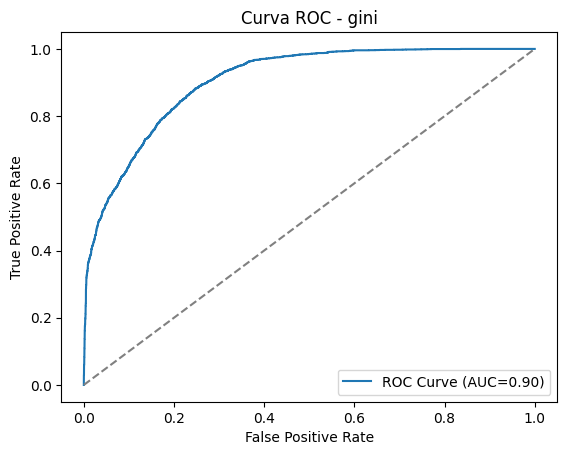

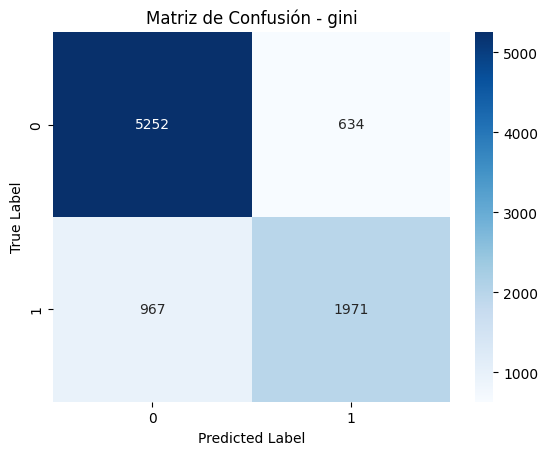


--------------------------------------------------
Modelo Optimizado 46
--------------------------------------------------
Criterion: gini, n_estimators: 200, Max Depth: 10, Min Samples Split: 5, Min Samples Leaf: 2

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      5886
           1       0.76      0.67      0.71      2938

    accuracy                           0.82      8824
   macro avg       0.80      0.78      0.79      8824
weighted avg       0.82      0.82      0.82      8824


ROC-AUC Score: 0.9048807880706882



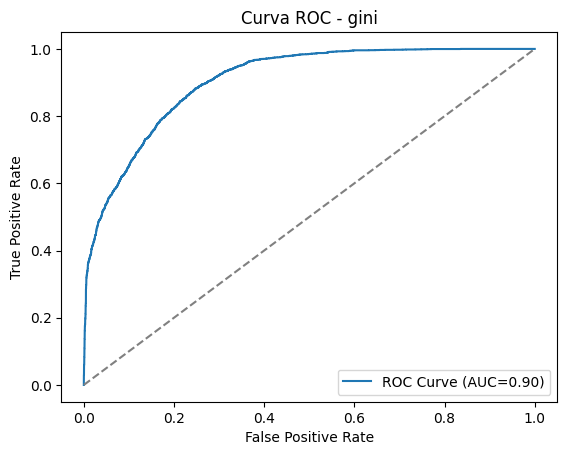

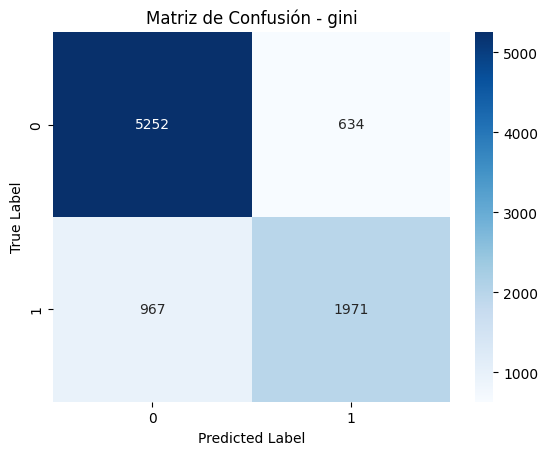


--------------------------------------------------
Modelo Optimizado 73
--------------------------------------------------
Criterion: gini, n_estimators: 300, Max Depth: 10, Min Samples Split: 5, Min Samples Leaf: 2

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      5886
           1       0.76      0.67      0.71      2938

    accuracy                           0.82      8824
   macro avg       0.80      0.78      0.79      8824
weighted avg       0.82      0.82      0.82      8824


ROC-AUC Score: 0.9048807880706882



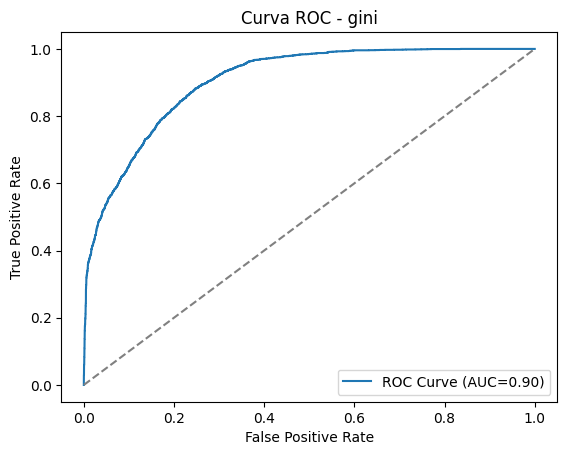

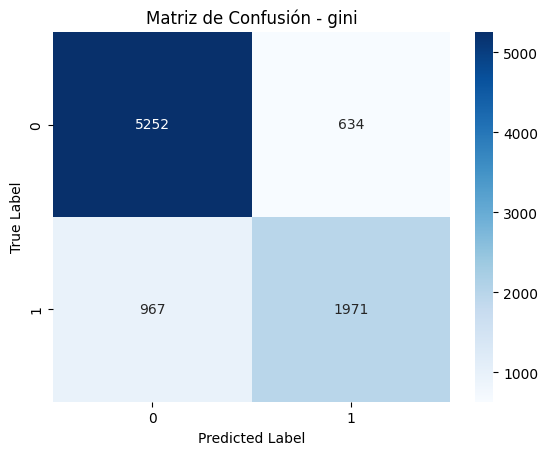

,criterion,n_estimators,max_depth,min_samples_split,min_samples_leaf,bootstrap,max_features,accuracy,f1_score,recall,roc_auc,cv_score,train_score,overfitting
18,gini,100,10,5,2,True,sqrt,0.823096,0.820176,0.823096,0.905950,0.824026,0.851990,OK
45,gini,200,10,5,2,True,sqrt,0.821623,0.818768,0.821623,0.906925,0.823828,0.853945,OK
72,gini,300,10,5,2,True,sqrt,0.820943,0.818116,0.820943,0.907197,0.824309,0.853549,OK


In [ ]:
import os
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, precision_recall_curve

# 📌 1️⃣ Cargar los datos (asumiendo que ya lo tienes cargado en df)
# Eliminar la columna "Tiempo" (si existe)
df = df.drop(columns=["Tiempo"], errors="ignore")

# 📌 2️⃣ Definir X e y
y = df["Mas_1_coche"]
X = df.drop(columns=["Mas_1_coche"])

# 📌 3️⃣ Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 📌 4️⃣ Definir hiperparámetros a iterar
param_grid = {
    'criterion': ['gini', 'entropy'],  # Función de impureza
    'n_estimators': [100, 200, 300],  # Número de árboles
    'max_depth': [3, 5, 10],  # Profundidad máxima
    'min_samples_split': [5, 10, 20],  # Mínimas muestras para dividir un nodo
    'min_samples_leaf': [2, 5, 10],  # Mínimas muestras en hojas
    'bootstrap': [True],  # Usar muestreo con reemplazo
    'max_features': ['sqrt'],  # Selección de características en cada split
}

"""Explicación de hiperparámetros:
- `criterion`: Forma de calcular la impureza del árbol. 'gini' y 'entropy' son comunes.
- `n_estimators`: Más árboles pueden reducir la varianza pero aumentan el tiempo de cómputo.
- `max_depth`: Limitar la profundidad evita sobreajuste.
- `min_samples_split`: Controla cuándo un nodo se divide.
- `min_samples_leaf`: Evita que haya nodos con muy pocos datos.
- `bootstrap`: Permite el muestreo con reemplazo para robustez.
- `max_features`: Usa la raíz cuadrada del total de features para cada split, acelerando el modelo.
"""

# 📌 5️⃣ Almacenar resultados
results = []

# 📌 6️⃣ Iterar sobre todas las combinaciones de hiperparámetros
for params in product(*param_grid.values()):
    criterion, n_estimators, max_depth, min_samples_split, min_samples_leaf, bootstrap, max_features = params

    # 📌 7️⃣ Construir el modelo con los hiperparámetros actuales
    model = RandomForestClassifier(
        criterion=criterion,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        max_features=max_features,
        n_jobs=-1,  # Paralelización
        random_state=42
    )

    # 📌 8️⃣ Entrenar el modelo
    model.fit(X_train, y_train)

    # 📌 9️⃣ Predecir en el conjunto de prueba
    y_pred = model.predict(X_test)

    # 📌 🔟 Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    # 📌 🔢 Calcular ROC-AUC si hay más de una clase
    if len(np.unique(y_test)) > 1:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc_auc = None

    # 📌 🔄 Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
    mean_cv_score = np.mean(cv_scores)

    # 📌 🏆 Calcular Train Score
    train_score = model.score(X_train, y_train)

    # 📌 🚨 Determinar si hay sobreajuste
    if train_score > 1.5 * mean_cv_score:
        overfitting_warning = "SEVERE OVERFITTING"
    elif train_score > 1.2 * mean_cv_score:
        overfitting_warning = "DANGER"
    elif train_score > 1.1 * mean_cv_score:
        overfitting_warning = "MILD OVERFITTING"
    else:
        overfitting_warning = "OK"

    # 📌 Guardar los resultados
    results.append({
        'criterion': criterion,
        'n_estimators': n_estimators,
        'max_depth': int(max_depth) if pd.notna(max_depth) else None,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap,
        'max_features': max_features,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,
        'roc_auc': roc_auc,
        'cv_score': mean_cv_score,
        'train_score': train_score,
        'overfitting': overfitting_warning
    })

    # 📌 Mostrar resultados parciales
    print(f"Criterion: {criterion}, n_estimators: {n_estimators}, Max Depth: {max_depth}, Min Samples Split: {min_samples_split}, Min Samples Leaf: {min_samples_leaf}, Bootstrap: {bootstrap}")
    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}, ROC-AUC: {roc_auc}, CV Score: {mean_cv_score:.4f}, Train Score: {train_score:.4f}, Overfitting: {overfitting_warning}\n")

# 📌 1️⃣1️⃣ Convertir resultados a DataFrame y seleccionar los mejores modelos
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['f1_score', 'accuracy'], ascending=False)

# 📌 1️⃣2️⃣ Seleccionar los mejores 3 modelos sin sobreajuste
best_models = results_df[results_df['overfitting'] == 'OK'].head(3)

# 📌 1️⃣3️⃣ Mostrar los mejores modelos con detalles
for index, row in best_models.iterrows():
    print('\n' + '-' * 50)
    print(f'Modelo Optimizado {index + 1}')
    print('-' * 50)
    print(f'Criterion: {row["criterion"]}, n_estimators: {row["n_estimators"]}, Max Depth: {row["max_depth"]}, Min Samples Split: {row["min_samples_split"]}, Min Samples Leaf: {row["min_samples_leaf"]}')
    print(f'\nClassification Report:')
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    if len(np.unique(y_test)) > 1:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f'\nROC-AUC Score: {roc_auc}\n')

        # 📌 Curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Curva ROC - {row["criterion"]}')
        plt.legend()
        plt.show()

        # 📌 Matriz de confusión
        plt.figure()
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusión - {row["criterion"]}')
        plt.show()

# 📌 Mostrar los mejores modelos
from IPython.display import display
display(best_models)


In [14]:
df.shape

(44119, 22)

Criterion: gini, n_estimators: 500, Max Depth: 15, Min Samples Split: 5, Min Samples Leaf: 2, Bootstrap: True
Accuracy: 0.8298, F1 Score: 0.8275, Recall: 0.8298, ROC-AUC: 0.9172430826039659, CV Score: 0.8310, Train Score: 0.9230, Overfitting: MILD OVERFITTING

Criterion: gini, n_estimators: 500, Max Depth: 15, Min Samples Split: 5, Min Samples Leaf: 3, Bootstrap: True
Accuracy: 0.8282, F1 Score: 0.8259, Recall: 0.8282, ROC-AUC: 0.9162730407351662, CV Score: 0.8313, Train Score: 0.9144, Overfitting: OK

Criterion: gini, n_estimators: 500, Max Depth: 15, Min Samples Split: 5, Min Samples Leaf: 5, Bootstrap: True
Accuracy: 0.8248, F1 Score: 0.8225, Recall: 0.8248, ROC-AUC: 0.9146737872076836, CV Score: 0.8298, Train Score: 0.8967, Overfitting: OK

Criterion: gini, n_estimators: 500, Max Depth: 15, Min Samples Split: 10, Min Samples Leaf: 2, Bootstrap: True
Accuracy: 0.8267, F1 Score: 0.8246, Recall: 0.8267, ROC-AUC: 0.9167532909718507, CV Score: 0.8305, Train Score: 0.9107, Overfitting: O

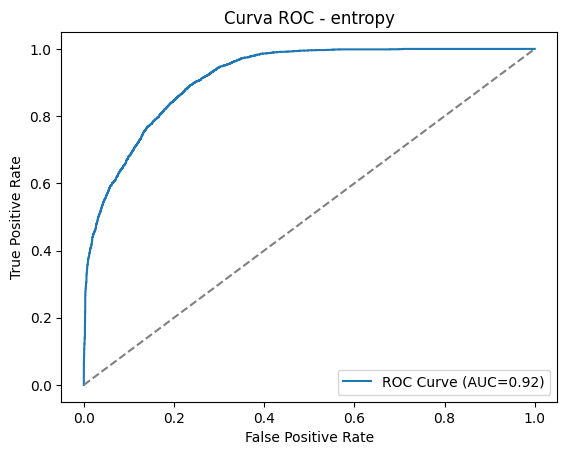

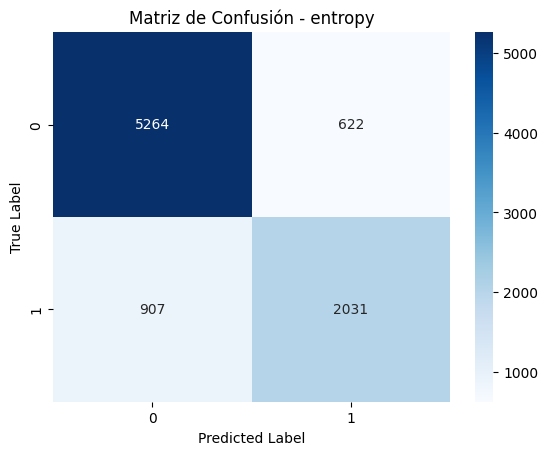


--------------------------------------------------
Modelo Optimizado 14
--------------------------------------------------
Criterion: entropy, n_estimators: 500, Max Depth: 15, Min Samples Split: 5, Min Samples Leaf: 3

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      5886
           1       0.77      0.69      0.73      2938

    accuracy                           0.83      8824
   macro avg       0.81      0.79      0.80      8824
weighted avg       0.82      0.83      0.82      8824


ROC-AUC Score: 0.9160098138745537



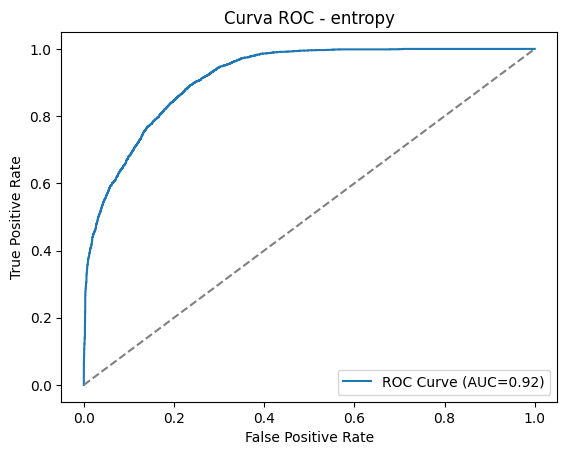

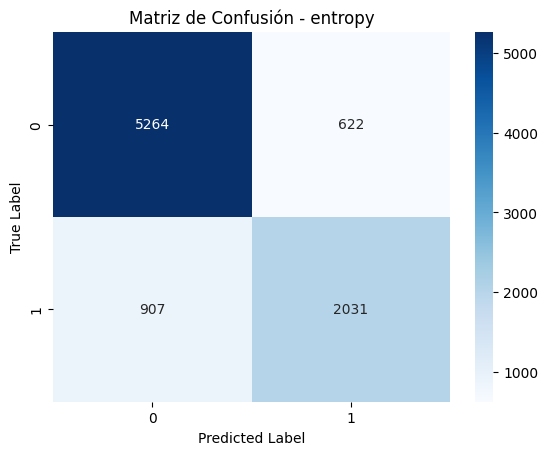


--------------------------------------------------
Modelo Optimizado 2
--------------------------------------------------
Criterion: gini, n_estimators: 500, Max Depth: 15, Min Samples Split: 5, Min Samples Leaf: 3

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      5886
           1       0.77      0.69      0.73      2938

    accuracy                           0.83      8824
   macro avg       0.81      0.79      0.80      8824
weighted avg       0.82      0.83      0.82      8824


ROC-AUC Score: 0.9160098138745537



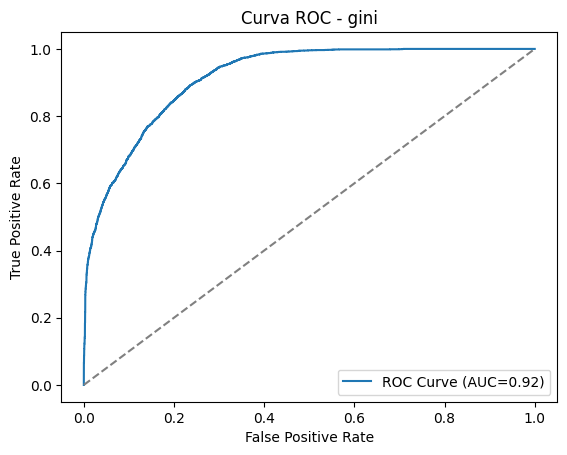

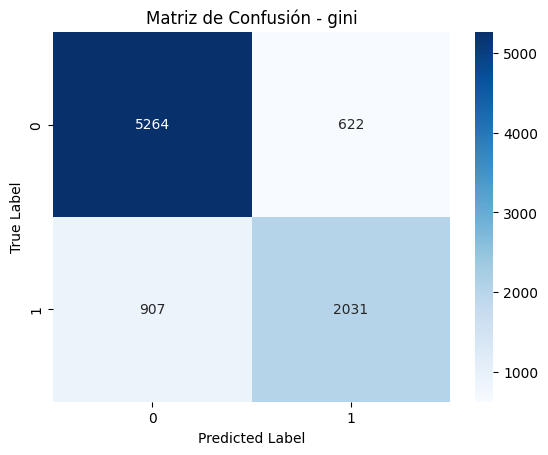

,criterion,n_estimators,max_depth,min_samples_split,min_samples_leaf,bootstrap,max_features,accuracy,f1_score,recall,roc_auc,cv_score,train_score,overfitting
16,entropy,500,15,10,3,True,sqrt,0.828422,0.826412,0.828422,0.916792,0.830628,0.905964,OK
13,entropy,500,15,5,3,True,sqrt,0.828083,0.825915,0.828083,0.917304,0.830996,0.912849,OK
1,gini,500,15,5,3,True,sqrt,0.828196,0.825893,0.828196,0.916273,0.831336,0.914435,OK


In [ ]:
import os
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, precision_recall_curve

# 📌 1️⃣ Cargar los datos (asumiendo que ya lo tienes cargado en df)
# Eliminar la columna "Tiempo" (si existe)
df = df.drop(columns=["Tiempo"], errors="ignore")

# 📌 2️⃣ Definir X e y
y = df["Mas_1_coche"]
X = df.drop(columns=["Mas_1_coche"])

# 📌 3️⃣ Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 📌 4️⃣ Definir hiperparámetros a iterar
param_grid = {
    'criterion': ['gini', 'entropy'],  # Función de impureza
    'n_estimators': [500],  # Número de árboles
    'max_depth': [15,20],  # Profundidad máxima
    'min_samples_split': [5, 10],  # Mínimas muestras para dividir un nodo
    'min_samples_leaf': [2, 3, 5],  # Mínimas muestras en hojas
    'bootstrap': [True],  # Usar muestreo con reemplazo
    'max_features': ['sqrt'],  # Selección de características en cada split
}

"""Explicación de hiperparámetros:
- `criterion`: Forma de calcular la impureza del árbol. 'gini' y 'entropy' son comunes.
- `n_estimators`: Más árboles pueden reducir la varianza pero aumentan el tiempo de cómputo.
- `max_depth`: Limitar la profundidad evita sobreajuste.
- `min_samples_split`: Controla cuándo un nodo se divide.
- `min_samples_leaf`: Evita que haya nodos con muy pocos datos.
- `bootstrap`: Permite el muestreo con reemplazo para robustez.
- `max_features`: Usa la raíz cuadrada del total de features para cada split, acelerando el modelo.
"""

# 📌 5️⃣ Almacenar resultados
results = []

# 📌 6️⃣ Iterar sobre todas las combinaciones de hiperparámetros
for params in product(*param_grid.values()):
    criterion, n_estimators, max_depth, min_samples_split, min_samples_leaf, bootstrap, max_features = params

    # 📌 7️⃣ Construir el modelo con los hiperparámetros actuales
    model = RandomForestClassifier(
        criterion=criterion,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        max_features=max_features,
        n_jobs=-1,  # Paralelización
        random_state=42
    )

    # 📌 8️⃣ Entrenar el modelo
    model.fit(X_train, y_train)

    # 📌 9️⃣ Predecir en el conjunto de prueba
    y_pred = model.predict(X_test)

    # 📌 🔟 Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    # 📌 🔢 Calcular ROC-AUC si hay más de una clase
    if len(np.unique(y_test)) > 1:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc_auc = None

    # 📌 🔄 Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
    mean_cv_score = np.mean(cv_scores)

    # 📌 🏆 Calcular Train Score
    train_score = model.score(X_train, y_train)

    # 📌 🚨 Determinar si hay sobreajuste
    if train_score > 1.5 * mean_cv_score:
        overfitting_warning = "SEVERE OVERFITTING"
    elif train_score > 1.2 * mean_cv_score:
        overfitting_warning = "DANGER"
    elif train_score > 1.1 * mean_cv_score:
        overfitting_warning = "MILD OVERFITTING"
    else:
        overfitting_warning = "OK"

    # 📌 Guardar los resultados
    results.append({
        'criterion': criterion,
        'n_estimators': n_estimators,
        'max_depth': int(max_depth) if pd.notna(max_depth) else None,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap,
        'max_features': max_features,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,
        'roc_auc': roc_auc,
        'cv_score': mean_cv_score,
        'train_score': train_score,
        'overfitting': overfitting_warning
    })

    # 📌 Mostrar resultados parciales
    print(f"Criterion: {criterion}, n_estimators: {n_estimators}, Max Depth: {max_depth}, Min Samples Split: {min_samples_split}, Min Samples Leaf: {min_samples_leaf}, Bootstrap: {bootstrap}")
    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}, ROC-AUC: {roc_auc}, CV Score: {mean_cv_score:.4f}, Train Score: {train_score:.4f}, Overfitting: {overfitting_warning}\n")

# 📌 1️⃣1️⃣ Convertir resultados a DataFrame y seleccionar los mejores modelos
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['f1_score', 'accuracy'], ascending=False)

# 📌 1️⃣2️⃣ Seleccionar los mejores 3 modelos sin sobreajuste
best_models = results_df[results_df['overfitting'] == 'OK'].head(3)

# 📌 1️⃣3️⃣ Mostrar los mejores modelos con detalles
for index, row in best_models.iterrows():
    print('\n' + '-' * 50)
    print(f'Modelo Optimizado {index + 1}')
    print('-' * 50)
    print(f'Criterion: {row["criterion"]}, n_estimators: {row["n_estimators"]}, Max Depth: {row["max_depth"]}, Min Samples Split: {row["min_samples_split"]}, Min Samples Leaf: {row["min_samples_leaf"]}')
    print(f'\nClassification Report:')
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    if len(np.unique(y_test)) > 1:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f'\nROC-AUC Score: {roc_auc}\n')

        # 📌 Curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Curva ROC - {row["criterion"]}')
        plt.legend()
        plt.show()

        # 📌 Matriz de confusión
        plt.figure()
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusión - {row["criterion"]}')
        plt.show()

# 📌 Mostrar los mejores modelos
from IPython.display import display
display(best_models)

Criterion: gini, n_estimators: 550, Max Depth: 10, Min Samples Split: 4, Min Samples Leaf: 2, Bootstrap: True
Accuracy: 0.8313, F1 Score: 0.8292, Recall: 0.8313, ROC-AUC: 0.920449164948637, CV Score: 0.8334, Train Score: 0.8723, Overfitting: OK

Criterion: gini, n_estimators: 550, Max Depth: 10, Min Samples Split: 4, Min Samples Leaf: 3, Bootstrap: True
Accuracy: 0.8310, F1 Score: 0.8290, Recall: 0.8310, ROC-AUC: 0.9203293192393622, CV Score: 0.8329, Train Score: 0.8707, Overfitting: OK

Criterion: gini, n_estimators: 550, Max Depth: 10, Min Samples Split: 4, Min Samples Leaf: 5, Bootstrap: True
Accuracy: 0.8298, F1 Score: 0.8278, Recall: 0.8298, ROC-AUC: 0.9196484973053942, CV Score: 0.8326, Train Score: 0.8674, Overfitting: OK

Criterion: gini, n_estimators: 550, Max Depth: 10, Min Samples Split: 5, Min Samples Leaf: 2, Bootstrap: True
Accuracy: 0.8313, F1 Score: 0.8292, Recall: 0.8313, ROC-AUC: 0.920446129050091, CV Score: 0.8333, Train Score: 0.8717, Overfitting: OK

Criterion: gin

c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Criterion: entropy, n_estimators: 550, Max Depth: 15, Min Samples Split: 10, Min Samples Leaf: 2, Bootstrap: True
Accuracy: 0.8387, F1 Score: 0.8377, Recall: 0.8387, ROC-AUC: 0.9274220456427974, CV Score: 0.8415, Train Score: 0.9333, Overfitting: MILD OVERFITTING

Criterion: entropy, n_estimators: 550, Max Depth: 15, Min Samples Split: 10, Min Samples Leaf: 3, Bootstrap: True
Accuracy: 0.8370, F1 Score: 0.8360, Recall: 0.8370, ROC-AUC: 0.926905191143642, CV Score: 0.8409, Train Score: 0.9310, Overfitting: MILD OVERFITTING

Criterion: entropy, n_estimators: 550, Max Depth: 15, Min Samples Split: 10, Min Samples Leaf: 5, Bootstrap: True
Accuracy: 0.8344, F1 Score: 0.8333, Recall: 0.8344, ROC-AUC: 0.9253843794519283, CV Score: 0.8394, Train Score: 0.9249, Overfitting: MILD OVERFITTING

Criterion: entropy, n_estimators: 550, Max Depth: 20, Min Samples Split: 4, Min Samples Leaf: 2, Bootstrap: True
Accuracy: 0.8401, F1 Score: 0.8392, Recall: 0.8401, ROC-AUC: 0.9267202904655206, CV Score: 0.

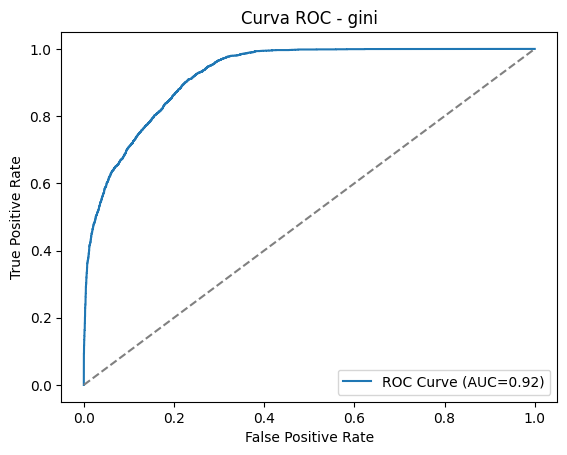

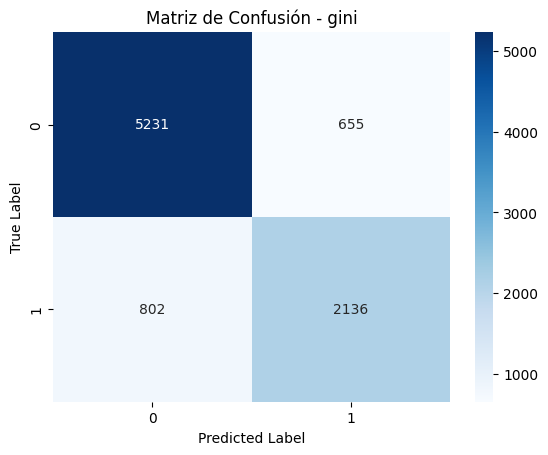


--------------------------------------------------
Modelo Optimizado 4
--------------------------------------------------
Criterion: gini, n_estimators: 550, Max Depth: 10, Min Samples Split: 5, Min Samples Leaf: 2

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      5886
           1       0.77      0.73      0.75      2938

    accuracy                           0.83      8824
   macro avg       0.82      0.81      0.81      8824
weighted avg       0.83      0.83      0.83      8824


ROC-AUC Score: 0.9246241615426483



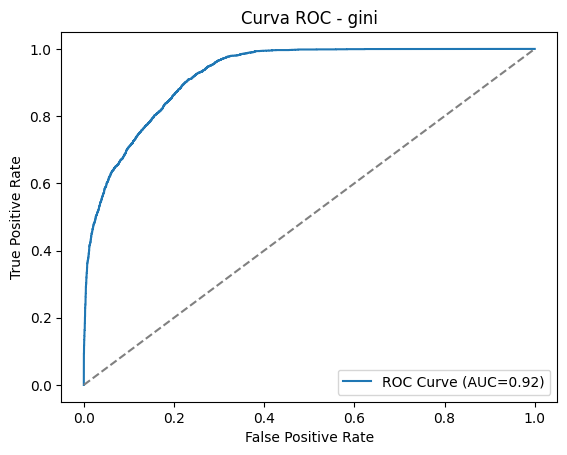

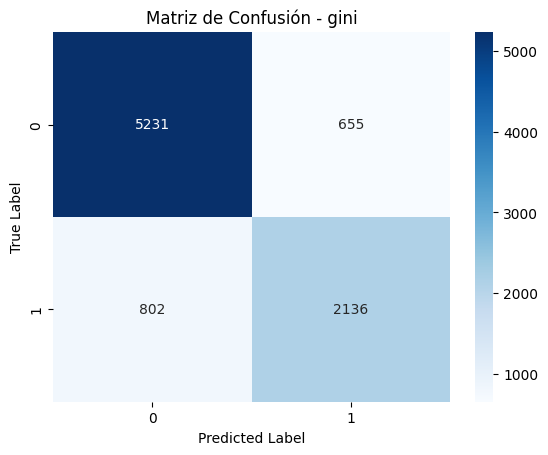


--------------------------------------------------
Modelo Optimizado 2
--------------------------------------------------
Criterion: gini, n_estimators: 550, Max Depth: 10, Min Samples Split: 4, Min Samples Leaf: 3

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      5886
           1       0.77      0.73      0.75      2938

    accuracy                           0.83      8824
   macro avg       0.82      0.81      0.81      8824
weighted avg       0.83      0.83      0.83      8824


ROC-AUC Score: 0.9246241615426483



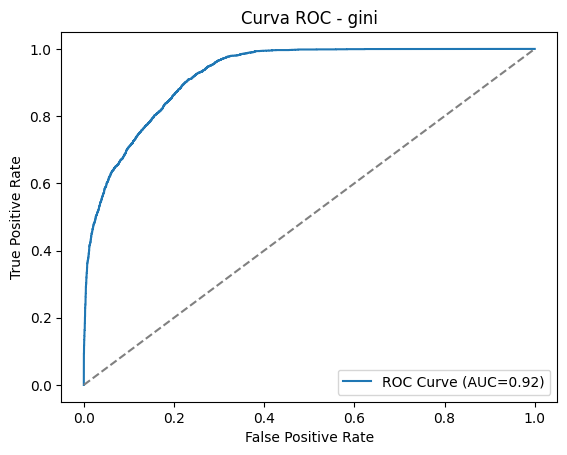

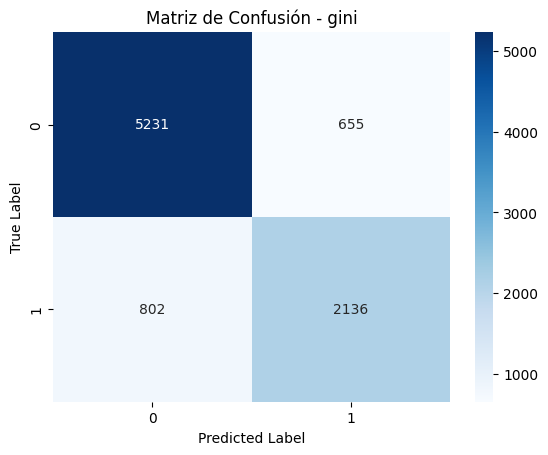

,criterion,n_estimators,max_depth,min_samples_split,min_samples_leaf,bootstrap,max_features,accuracy,f1_score,recall,roc_auc,cv_score,train_score,overfitting
0,gini,550,10,4,2,True,None,0.831256,0.829217,0.831256,0.920449,0.833404,0.872277,OK
3,gini,550,10,5,2,True,None,0.831256,0.829199,0.831256,0.920446,0.833348,0.871653,OK
1,gini,550,10,4,3,True,None,0.831029,0.829005,0.831029,0.920329,0.832894,0.870662,OK


In [18]:
import os
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, precision_recall_curve

# 📌 1️⃣ Cargar los datos (asumiendo que ya lo tienes cargado en df)
# Eliminar la columna "Tiempo" (si existe)
df = df.drop(columns=["Tiempo"], errors="ignore")

# 📌 2️⃣ Definir X e y
y = df["Mas_1_coche"]
X = df.drop(columns=["Mas_1_coche"])

# 📌 3️⃣ Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 📌 4️⃣ Definir hiperparámetros a iterar
param_grid = {
    'criterion': ['gini', 'entropy'],  # Función de impureza
    'n_estimators': [550],  # Número de árboles
    'max_depth': [10,15,20],  # Profundidad máxima
    'min_samples_split': [4,5,10],  # Mínimas muestras para dividir un nodo
    'min_samples_leaf': [2, 3,5],  # Mínimas muestras en hojas
    'bootstrap': [True],  # Usar muestreo con reemplazo
    'max_features': [None],  # Selección de características en cada split
}

"""Explicación de hiperparámetros:
- `criterion`: Forma de calcular la impureza del árbol. 'gini' y 'entropy' son comunes.
- `n_estimators`: Más árboles pueden reducir la varianza pero aumentan el tiempo de cómputo.
- `max_depth`: Limitar la profundidad evita sobreajuste.
- `min_samples_split`: Controla cuándo un nodo se divide.
- `min_samples_leaf`: Evita que haya nodos con muy pocos datos.
- `bootstrap`: Permite el muestreo con reemplazo para robustez.
- `max_features`: Usa la raíz cuadrada del total de features para cada split, acelerando el modelo.
"""

# 📌 5️⃣ Almacenar resultados
results = []

# 📌 6️⃣ Iterar sobre todas las combinaciones de hiperparámetros
for params in product(*param_grid.values()):
    criterion, n_estimators, max_depth, min_samples_split, min_samples_leaf, bootstrap, max_features = params

    # 📌 7️⃣ Construir el modelo con los hiperparámetros actuales
    model = RandomForestClassifier(
        criterion=criterion,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        max_features=max_features,
        n_jobs=-1,  # Paralelización
        random_state=42
    )

    # 📌 8️⃣ Entrenar el modelo
    model.fit(X_train, y_train)

    # 📌 9️⃣ Predecir en el conjunto de prueba
    y_pred = model.predict(X_test)

    # 📌 🔟 Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    # 📌 🔢 Calcular ROC-AUC si hay más de una clase
    if len(np.unique(y_test)) > 1:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc_auc = None

    # 📌 🔄 Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=6, n_jobs=-1)
    mean_cv_score = np.mean(cv_scores)

    # 📌 🏆 Calcular Train Score
    train_score = model.score(X_train, y_train)

    # 📌 🚨 Determinar si hay sobreajuste
    if train_score > 1.5 * mean_cv_score:
        overfitting_warning = "SEVERE OVERFITTING"
    elif train_score > 1.2 * mean_cv_score:
        overfitting_warning = "DANGER"
    elif train_score > 1.1 * mean_cv_score:
        overfitting_warning = "MILD OVERFITTING"
    else:
        overfitting_warning = "OK"

    # 📌 Guardar los resultados
    results.append({
        'criterion': criterion,
        'n_estimators': n_estimators,
        'max_depth': int(max_depth) if pd.notna(max_depth) else None,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap,
        'max_features': max_features,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,
        'roc_auc': roc_auc,
        'cv_score': mean_cv_score,
        'train_score': train_score,
        'overfitting': overfitting_warning
    })

    # 📌 Mostrar resultados parciales
    print(f"Criterion: {criterion}, n_estimators: {n_estimators}, Max Depth: {max_depth}, Min Samples Split: {min_samples_split}, Min Samples Leaf: {min_samples_leaf}, Bootstrap: {bootstrap}")
    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}, ROC-AUC: {roc_auc}, CV Score: {mean_cv_score:.4f}, Train Score: {train_score:.4f}, Overfitting: {overfitting_warning}\n")

# 📌 1️⃣1️⃣ Convertir resultados a DataFrame y seleccionar los mejores modelos
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['f1_score', 'accuracy'], ascending=False)

# 📌 1️⃣2️⃣ Seleccionar los mejores 3 modelos sin sobreajuste
best_models = results_df[results_df['overfitting'] == 'OK'].head(3)

# 📌 1️⃣3️⃣ Mostrar los mejores modelos con detalles
for index, row in best_models.iterrows():
    print('\n' + '-' * 50)
    print(f'Modelo Optimizado {index + 1}')
    print('-' * 50)
    print(f'Criterion: {row["criterion"]}, n_estimators: {row["n_estimators"]}, Max Depth: {row["max_depth"]}, Min Samples Split: {row["min_samples_split"]}, Min Samples Leaf: {row["min_samples_leaf"]}')
    print(f'\nClassification Report:')
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    if len(np.unique(y_test)) > 1:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f'\nROC-AUC Score: {roc_auc}\n')

        # 📌 Curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Curva ROC - {row["criterion"]}')
        plt.legend()
        plt.show()

        # 📌 Matriz de confusión
        plt.figure()
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusión - {row["criterion"]}')
        plt.show()

# 📌 Mostrar los mejores modelos
from IPython.display import display
display(best_models)